<center><H1>Putting it all together: Py-ART, S3, Siphon, Boto and MetPy</H1></center>

In [1]:
#First out imports
#Lets import some stuff!
from datetime import datetime
import os
import tempfile

from boto.s3.connection import S3Connection
import cartopy
import matplotlib.patheffects as mpatheffects
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.plots import simple_layout, StationPlot, StationPlotLayout
from metpy.plots.wx_symbols import sky_cover, current_weather
from metpy.units import units
from netCDF4 import num2date
import numpy as np
import pyart
import pytz
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS

%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
#Now our nifty fetch script
#Helper function for the search
def _nearestDate(dates, pivot):
    return min(dates, key=lambda x: abs(x - pivot))


def get_radar_from_aws(site, datetime_t):
    """
    Get the closest volume of NEXRAD data to a particular datetime.
    Parameters
    ----------
    site : string
        four letter radar designation
    datetime_t : datetime
        desired date time
    Returns
    -------
    radar : Py-ART Radar Object
        Radar closest to the queried datetime
    """

    # First create the query string for the bucket knowing
    # how NOAA and AWS store the data
    my_pref = datetime_t.strftime('%Y/%m/%d/') + site

    # Connect to the bucket
    conn = S3Connection(anon = True)
    bucket = conn.get_bucket('noaa-nexrad-level2')

    # Get a list of files
    bucket_list = list(bucket.list(prefix = my_pref))

    # we are going to create a list of keys and datetimes to allow easy searching
    keys = []
    datetimes = []

    # populate the list
    for i in range(len(bucket_list)):
        this_str = str(bucket_list[i].key)
        if 'gz' in this_str:
            endme = this_str[-22:-4]
            fmt = '%Y%m%d_%H%M%S_V0'
            dt = datetime.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket_list[i])

        if this_str[-3::] == 'V06':
            endme = this_str[-19::]
            fmt = '%Y%m%d_%H%M%S_V06'
            dt = datetime.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket_list[i])

    # find the closest available radar to your datetime
    closest_datetime = _nearestDate(datetimes, datetime_t)
    index = datetimes.index(closest_datetime)

    localfile = tempfile.NamedTemporaryFile()
    keys[index].get_contents_to_filename(localfile.name)
    radar = pyart.io.read(localfile.name)
    return radar

In [3]:
# Lets grab the latest radar volume from Seattle
station = 'KATX'
my_datetime = datetime.utcnow()
radar = get_radar_from_aws(station, my_datetime)

In [4]:
# Lets get some geographical context
lats = radar.gate_latitude
lons = radar.gate_longitude

min_lon = lons['data'].min()
min_lat = lats['data'].min()
max_lat = lats['data'].max()
max_lon = lons['data'].max()

print('min_lat:', min_lat, ' min_lon:', min_lon, 
      ' max_lat:', max_lat, ' max_lon:', max_lon)

sweep = 0
index_at_start = radar.sweep_start_ray_index['data'][sweep]
time_at_start_of_radar = num2date(radar.time['data'][index_at_start], 
                                  radar.time['units'])
pacific = pytz.timezone('US/Pacific')
local_time = pacific.fromutc(time_at_start_of_radar)
fancy_date_string = local_time.strftime('%A %B %d at %I:%M %p %Z')
print(fancy_date_string)

min_lat: 44.0651505369  min_lon: -128.69726168  max_lat: 52.3240680373  max_lon: -116.29413111
Friday January 20 at 03:11 PM PST


/Users/rmay/miniconda3/envs/ams-workshop/lib/python3.5/site-packages/matplotlib/ticker.py:1693: UserWarning: Steps argument should be a sequence of numbers
increasing from 1 to 10, inclusive. Behavior with
values outside this range is undefined, and will
raise a ValueError in future versions of mpl.
  warnings.warn('Steps argument should be a sequence of numbers\n'


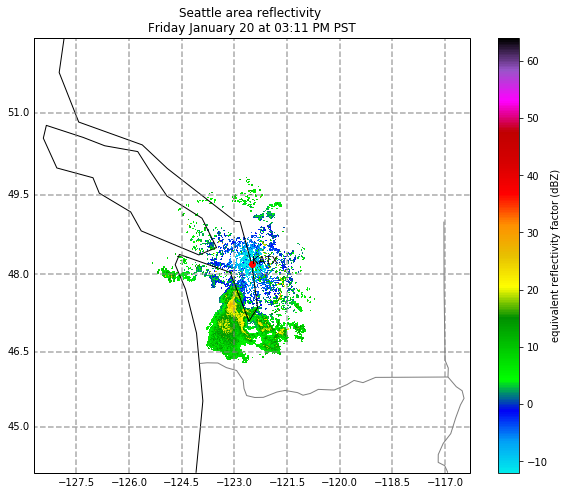

In [5]:
fig = plt.figure(figsize = [10,8])
display = pyart.graph.RadarMapDisplayCartopy(radar)
lat_0 = display.loc[0]
lon_0 = display.loc[1]

# Main difference! Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=min_lat, max_latitude=max_lat)

title = 'Seattle area reflectivity \n' + fancy_date_string

display.plot_ppi_map(
    'reflectivity', 0, colorbar_flag=True,
    title=title,
    projection=projection,
    min_lon=min_lon, max_lon=max_lon, min_lat=min_lat, max_lat=max_lat,
    vmin=-12, vmax=64)

# Mark the radar
display.plot_point(lon_0, lat_0, label_text='KATX')

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False


In [6]:
# copied from the browser url box
metar_cat_url = 'http://thredds.ucar.edu/thredds/catalog/nws/metar/ncdecoded/catalog.xml?dataset=nws/metar/ncdecoded/Metar_Station_Data_fc.cdmr'
# parse the xml
metar_cat = TDSCatalog(metar_cat_url)
# what datasets are here? only one "dataset" in this catalog
dataset = list(metar_cat.datasets.values())[0]
ncss_url = dataset.access_urls["NetcdfSubset"]
ncss = NCSS(ncss_url)

In [7]:
bb = {'north' : max_lat,
      'south' : min_lat,
      'east' : max_lon,
      'west' : min_lon}

query = ncss.query()
query.lonlat_box(**bb)
query.time(time_at_start_of_radar)
query.variables('air_temperature', 'dew_point_temperature', 'inches_ALTIM',
                'wind_speed', 'wind_from_direction', 'cloud_area_fraction', 'weather')
query.accept('csv')

var=weather&var=cloud_area_fraction&var=wind_from_direction&var=wind_speed&var=air_temperature&var=inches_ALTIM&var=dew_point_temperature&time=2017-01-20T23%3A11%3A45.299000&east=-116.29413111&west=-128.69726168&north=52.3240680373&south=44.0651505369&accept=csv

In [8]:
# Download the data
data = ncss.get_data(query)

# Access is just like netcdf4-python
lats = data['latitude'][:]
lons = data['longitude'][:]

# Get the data -- but only for the points we want to keep
tair = data['air_temperature']
dewp = data['dew_point_temperature']
slp = (data['inches_ALTIM'] * units('inHg')).to('mbar')

# Convert wind to components
u, v = mpcalc.get_wind_components(data['wind_speed'] * units.knot,
                                  data['wind_from_direction'] * units.deg)

# Need to handle missing (NaN) and convert to proper code
cloud_cover = 8 * data['cloud_area_fraction']
cloud_cover[np.isnan(cloud_cover)] = 9
cloud_cover = cloud_cover.astype(np.int)

# For some reason these come back as bytes instead of strings
stid = [s.decode() for s in data['station']]

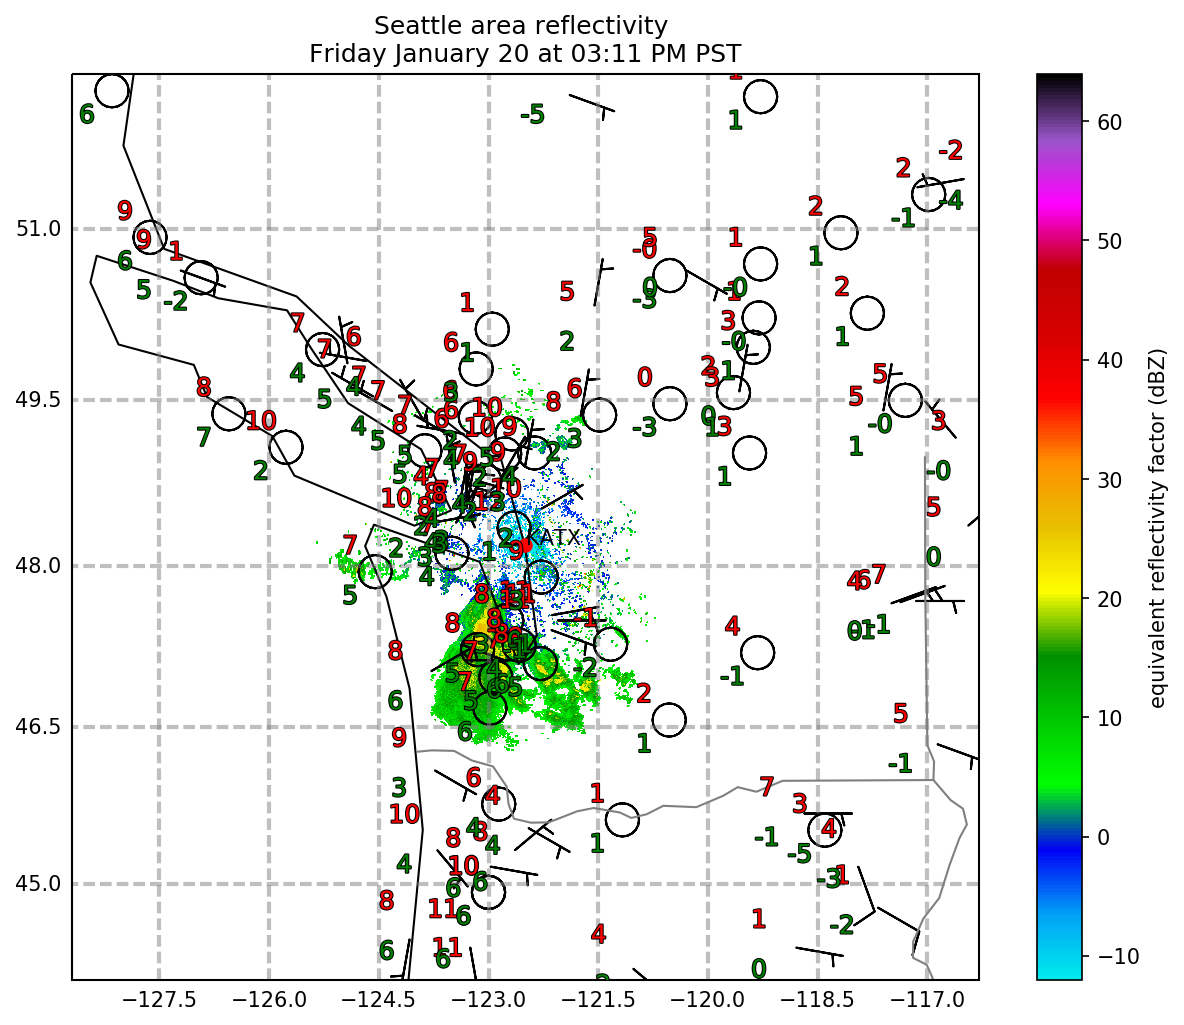

In [9]:
fig = plt.figure(figsize = (10, 8), dpi=150)
display = pyart.graph.RadarMapDisplayCartopy(radar)
lat_0 = display.loc[0]
lon_0 = display.loc[1]

# Main difference! Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=min_lat, max_latitude=max_lat)

title = 'Seattle area reflectivity \n' + fancy_date_string

display.plot_ppi_map(
    'reflectivity', 0, colorbar_flag=True,
    title=title,
    projection=projection,
    min_lon=min_lon, max_lon=max_lon, min_lat=min_lat, max_lat=max_lat,
    vmin=-12, vmax=64)

# Mark the radar
display.plot_point(lon_0, lat_0, label_text='KATX')

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

stationplot = StationPlot(display.ax, lons, lats, transform=cartopy.crs.PlateCarree(),
                          fontsize=12)

# Extra arguments for plotting text
plot_kwargs = dict(path_effects=[mpatheffects.withStroke(linewidth=1, foreground='black')],
                   clip_on=True)
stationplot.plot_parameter('NW', tair, color='red', **plot_kwargs)
stationplot.plot_parameter('SW', dewp, color='green', **plot_kwargs)

# Add wind barbs
stationplot.plot_barb(u, v)

In [10]:
# These will be in MetPy 0.5
from scipy.spatial import cKDTree

def thin_points(xy, radius, sort_key=None):
    # All points masked initially
    mask = np.ones(xy.shape[0], dtype=np.bool)

    if sort_key is not None:
        # Need in decreasing priority
        sorted_indices = np.argsort(sort_key)[::-1]
    else:
        sorted_indices = np.arange(len(xy))

    # Make our tree
    tree = cKDTree(xy)

    # Loop over all the potential points
    for sort_ind in sorted_indices:
        val = mask[sort_ind]
        # Only proceed if we haven't already excluded this point
        if val:
            # Loop over all the neighbors within the radius
            for neighbor in tree.query_ball_point(xy[sort_ind], radius):
                # Mask them out, but don't mask ourselves
                if neighbor != sort_ind:
                    mask[neighbor] = False

    return mask

wx_code_map = {'': 0, 'DU':7, 'BLDU':7, 'HZ': 5, 'BR': 10, '-UP':16, 'UP': 16, 'SQ': 18, 'FC': 19,
               'DRSN': 36, 'FG': 45, 'FZFG': 49, '-DZ': 51, 'DZ': 53, '+DZ': 55,
               '-RA': 61, 'RA': 63, '+RA': 65, '-FZRA': 66,
               '-SN': 71, 'SN': 73, '+SN': 75, '-SHRA': 80, 'SHRA': 81, '-SHSN': 85}
def to_code(text):
    for s in text:
        if ' ' in s:
            yield max(to_code(s.split()))
        else:
            yield wx_code_map[s]

In [11]:
# Function to do some data reduction for us
def filter_data(data_dict, projection, radius=100000, sort_key=None, bbox=None):
    'Reduce station density and remove stations outside given bounding box.'
    # Pull location information from our data dictionary
    lats = data_dict['latitude'][:]
    lons = data_dict['longitude'][:]

    # Project the lons and lats
    proj_pts = projection.transform_points(cartopy.crs.PlateCarree(), lons, lats)[..., :-1]

    # Only pay attention to points in the passed-in bounding box (if given)
    if bbox:
        min_lon, max_lon, min_lat, max_lat = bbox
        bounds_x, bounds_y = projection.transform_points(cartopy.crs.PlateCarree(),
                                                         np.array([min_lon, min_lon, max_lon, max_lon]),
                                                         np.array([min_lat, max_lat, min_lat, max_lat]))[..., :-1].T
        min_x = bounds_x.min()
        max_x = bounds_x.max()
        min_y = bounds_y.min()
        max_y = bounds_y.max()
        proj_x, proj_y = proj_pts.T
        box_mask = (proj_x > min_x) & (proj_x < max_x) & (proj_y > min_y) & (proj_y < max_y)
    else:
        box_mask = np.ones(lons.shape, dtype=np.bool)
    
    # Reduce the stations on the map--order by the specified field
    keep = thin_points(proj_pts, radius=radius, sort_key=data_dict.get(sort_key))
    
    # Combine the masks
    keep = keep & box_mask
    
    # Use the mask on every field in the dictionary--use keys so we can modify the dict
    # while iterating
    for key in data_dict.keys():
        data_dict[key] = data_dict[key][keep]

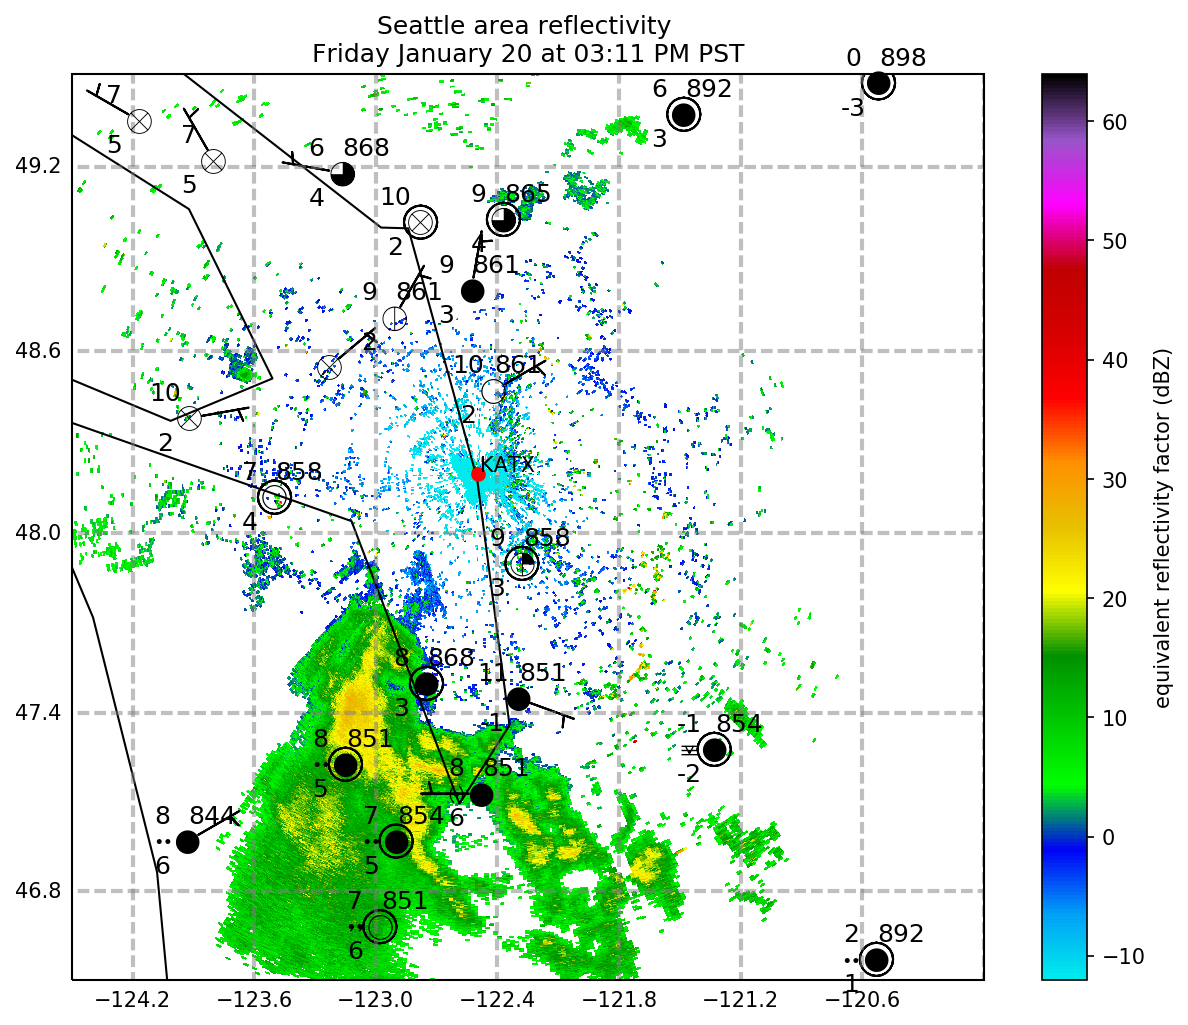

In [12]:
# Convert the text weather observations to WMO codes we can map to symbols
wx_text = [s.decode('ascii') for s in data['weather']]
wx_codes = np.array(list(to_code(wx_text)))

# Set up a dictionary with all the data
sfc_data = {'latitude': lats, 'longitude': lons,
            'air_temperature': tair, 'dew_point_temperature': dewp, 'eastward_wind': u,
            'northward_wind': v, 'cloud_coverage': cloud_cover,
            'air_pressure_at_sea_level': slp, 'present_weather': wx_codes}

# Call our function to reduce data
filter_data(sfc_data, projection, radius=40000., sort_key='present_weather',
            bbox=(-124.5, -120, 46.5, 49.5))

fig = plt.figure(figsize=(10, 8), dpi=150)
display = pyart.graph.RadarMapDisplayCartopy(radar)
display.plot_ppi_map(
    'reflectivity', 0, colorbar_flag=True,
    title='Seattle area reflectivity \n' + fancy_date_string,
    projection=projection,
    min_lon=-124.5, max_lon=-120, min_lat=46.5, max_lat=49.5,
    vmin=-12, vmax=64)

# Mark the radar
display.plot_point(lon_0, lat_0, label_text='KATX')

# Get the current axes and plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

# Now do the station plot using a canned layout
stationplot = StationPlot(display.ax, sfc_data['longitude'], sfc_data['latitude'],
                          transform=cartopy.crs.PlateCarree(), fontsize=12)
simple_layout.plot(stationplot, sfc_data)

min_lat: 26.5499873276  min_lon: -93.0429897964  max_lat: 34.8089091683  max_lon: -83.4370104993
Friday January 20 at 03:16 PM PST


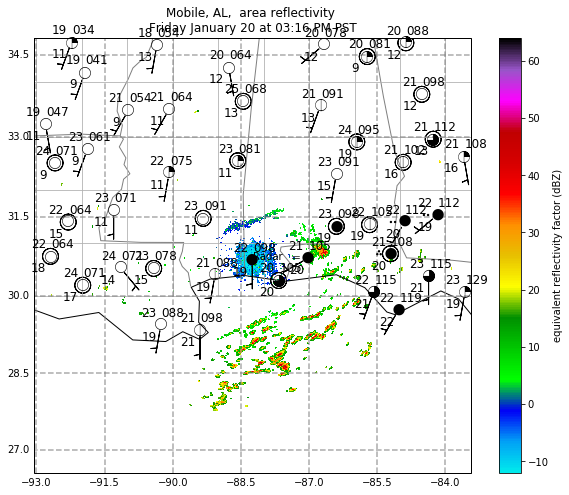

In [13]:
# All together now!

#
# Get Radar Data
#
station = 'KMOB'
radar_title = 'Mobile, AL, '
my_datetime = datetime.utcnow()
radar = get_radar_from_aws(station, my_datetime)

#
# Pull out time/space information from radar data
#
lats = radar.gate_latitude
lons = radar.gate_longitude

min_lon = lons['data'].min()
min_lat = lats['data'].min()
max_lat = lats['data'].max()
max_lon = lons['data'].max()

print('min_lat:', min_lat, ' min_lon:', min_lon, 
      ' max_lat:', max_lat, ' max_lon:', max_lon)

sweep = 0
index_at_start = radar.sweep_start_ray_index['data'][sweep]
time_at_start_of_radar = num2date(radar.time['data'][index_at_start], 
                                  radar.time['units'])
pacific = pytz.timezone('US/Pacific')
local_time = pacific.fromutc(time_at_start_of_radar)
fancy_date_string = local_time.strftime('%A %B %d at %I:%M %p %Z')
print(fancy_date_string)

#
# Get the METAR obs for this same time and place
#
metar_cat = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/nws/metar/ncdecoded/catalog.xml?'
                       'dataset=nws/metar/ncdecoded/Metar_Station_Data_fc.cdmr')
dataset = list(metar_cat.datasets.values())[0]
ncss = NCSS(dataset.access_urls["NetcdfSubset"])

query = ncss.query().accept('csv').time(time_at_start_of_radar)
query.lonlat_box(north=max_lat, south=min_lat, east=max_lon, west=min_lon)
query.variables('air_temperature', 'dew_point_temperature', 'inches_ALTIM',
                'wind_speed', 'wind_from_direction', 'cloud_area_fraction', 'weather')
data = ncss.get_data(query)

#
# Manipulate the downloaded data--someday this should be simpler
#
lats = data['latitude'][:]
lons = data['longitude'][:]
tair = data['air_temperature'][:]
dewp = data['dew_point_temperature'][:]
slp = (data['inches_ALTIM'][:] * units('inHg')).to('mbar')

# Convert wind to components
u, v = mpcalc.get_wind_components(data['wind_speed'] * units.knot,
                                  data['wind_from_direction'] * units.deg)

# Need to handle missing (NaN) and convert to proper code
cloud_cover = 8 * data['cloud_area_fraction']
cloud_cover[np.isnan(cloud_cover)] = 9
cloud_cover = cloud_cover.astype(np.int)

# For some reason these come back as bytes instead of strings
stid = [s.decode() for s in data['station']]

# Convert the text weather observations to WMO codes we can map to symbols
wx_text = [s.decode('ascii') for s in data['weather']]
wx_codes = np.array(list(to_code(wx_text)))

sfc_data = {'latitude': lats, 'longitude': lons,
            'air_temperature': tair, 'dew_point_temperature': dewp, 'eastward_wind': u,
            'northward_wind': v, 'cloud_coverage': cloud_cover,
            'air_pressure_at_sea_level': slp, 'present_weather': wx_codes}

#
# Plotting
#
fig = plt.figure(figsize=(10, 8))
display = pyart.graph.RadarMapDisplayCartopy(radar)
lat_0 = display.loc[0]
lon_0 = display.loc[1]

# Set our Projection
projection = cartopy.crs.Mercator(central_longitude=lon_0,
                                  min_latitude=min_lat, max_latitude=max_lat)

# Call our function to reduce data
filter_data(sfc_data, projection, radius=75000., sort_key='present_weather')

display.plot_ppi_map(
    'reflectivity', 0, colorbar_flag=True,
    title=radar_title +' area reflectivity \n' + fancy_date_string,
    projection=projection,
    min_lon=min_lon, max_lon=max_lon, min_lat=min_lat, max_lat=max_lat,
    vmin=-12, vmax=64)

# Mark the radar
display.plot_point(lon_0, lat_0, label_text='Radar')

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

# Make the station plot
stationplot = StationPlot(display.ax, sfc_data['longitude'], sfc_data['latitude'],
                          transform=cartopy.crs.PlateCarree(),
                          fontsize=12)
simple_layout.plot(stationplot, sfc_data)

In [14]:
# and finally we can make it into a function
def radar_plus_obs(station, my_datetime, radar_title=None, bb=None,
                   station_radius=75000., station_layout=simple_layout):
    if radar_title is None:
        radar_title = 'Area '
    
    radar = get_radar_from_aws(station, my_datetime)

    # Lets get some geographical context
    if bb is None:
        lats = radar.gate_latitude
        lons = radar.gate_longitude

        min_lon = lons['data'].min()
        min_lat = lats['data'].min()
        max_lat = lats['data'].max()
        max_lon = lons['data'].max()
        bb = {'north' : max_lat,
              'south' : min_lat,
              'east' : max_lon,
              'west' : min_lon}
    else:
        min_lon = bb['west']
        min_lat = bb['south']
        max_lon = bb['east']
        max_lat = bb['north']
        
    print('min_lat:', min_lat, ' min_lon:', min_lon, 
          ' max_lat:', max_lat, ' max_lon:', max_lon)

    sweep = 0
    index_at_start = radar.sweep_start_ray_index['data'][sweep]
    time_at_start_of_radar = num2date(radar.time['data'][index_at_start], 
                                      radar.time['units'])
    pacific = pytz.timezone('US/Pacific')
    local_time = pacific.fromutc(time_at_start_of_radar)
    fancy_date_string = local_time.strftime('%A %B %d at %I:%M %p %Z')
    print(fancy_date_string)

    metar_cat = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/nws/metar/ncdecoded/catalog.xml?'
                           'dataset=nws/metar/ncdecoded/Metar_Station_Data_fc.cdmr')
    dataset = list(metar_cat.datasets.values())[0]
    ncss = NCSS(dataset.access_urls["NetcdfSubset"])

    query = ncss.query().accept('csv').time(time_at_start_of_radar)
    query.lonlat_box(north=max_lat, south=min_lat, east=max_lon, west=min_lon)
    query.variables('air_temperature', 'dew_point_temperature', 'inches_ALTIM',
                    'wind_speed', 'wind_from_direction', 'cloud_area_fraction', 'weather')
    data = ncss.get_data(query)

    lats = data['latitude'][:]
    lons = data['longitude'][:]
    tair = data['air_temperature'][:]
    dewp = data['dew_point_temperature'][:]
    slp = (data['inches_ALTIM'][:] * units('inHg')).to('mbar')

    # Convert wind to components
    u, v = mpcalc.get_wind_components(data['wind_speed'] * units.knot,
                                      data['wind_from_direction'] * units.deg)

    # Need to handle missing (NaN) and convert to proper code
    cloud_cover = 8 * data['cloud_area_fraction']
    cloud_cover[np.isnan(cloud_cover)] = 9
    cloud_cover = cloud_cover.astype(np.int)

    # For some reason these come back as bytes instead of strings
    stid = [s.decode() for s in data['station']]

    # Convert the text weather observations to WMO codes we can map to symbols
    wx_text = [s.decode('ascii') for s in data['weather']]
    wx_codes = np.array(list(to_code(wx_text)))

    sfc_data = {'latitude': lats, 'longitude': lons,
                'air_temperature': tair, 'dew_point_temperature': dewp, 'eastward_wind': u,
                'northward_wind': v, 'cloud_coverage': cloud_cover,
                'air_pressure_at_sea_level': slp, 'present_weather': wx_codes}

    fig = plt.figure(figsize=(10, 8))
    display = pyart.graph.RadarMapDisplayCartopy(radar)
    lat_0 = display.loc[0]
    lon_0 = display.loc[1]

    # Set our Projection
    projection = cartopy.crs.Mercator(central_longitude=lon_0,
                                      min_latitude=min_lat, max_latitude=max_lat)

    # Call our function to reduce data
    filter_data(sfc_data, projection, radius=station_radius, sort_key='present_weather')

    display.plot_ppi_map(
        'reflectivity', 0, colorbar_flag=True,
        title=radar_title +' area reflectivity \n' + fancy_date_string,
        projection=projection,
        min_lon=min_lon, max_lon=max_lon, min_lat=min_lat, max_lat=max_lat,
        vmin=-12, vmax=64)

    # Mark the radar
    display.plot_point(lon_0, lat_0, label_text='Radar')

    # Get the current axes and plot some lat and lon lines
    gl = display.ax.gridlines(draw_labels=True,
                              linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False

    # Make the station plot
    stationplot = StationPlot(display.ax, sfc_data['longitude'], sfc_data['latitude'],
                              transform=cartopy.crs.PlateCarree(),
                              fontsize=12)
    station_layout.plot(stationplot, sfc_data)
    
    return display

min_lat: 35.8172313942  min_lon: -79.8010105601  max_lat: 44.0769403078  max_lon: -69.0204583588
Friday January 20 at 03:15 PM PST


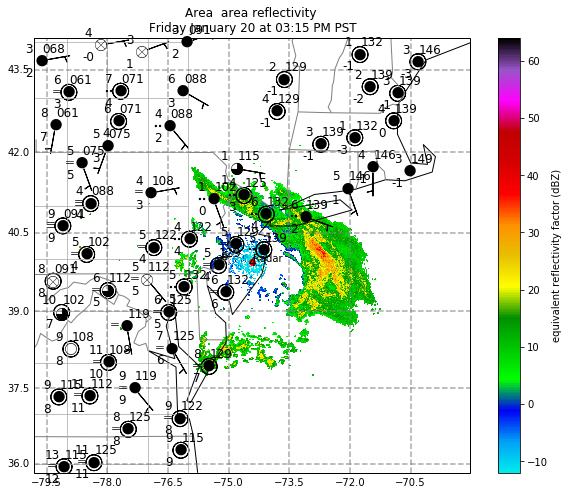

In [15]:
radar_plus_obs('KDIX', datetime.utcnow())

min_lat: 37.4749839026  min_lon: -93.6108091523  max_lat: 45.7338980511  max_lon: -82.5580747805
Friday January 20 at 03:13 PM PST


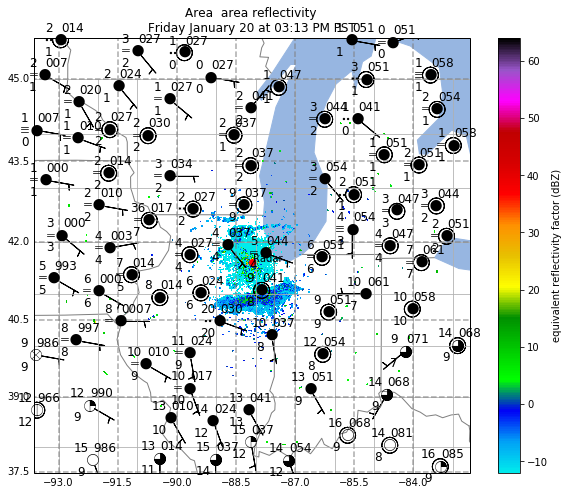

In [16]:
display = radar_plus_obs('KLOT', datetime.utcnow(), station_radius=90000.)
display.ax.add_feature(cartopy.feature.LAKES, zorder=0)

min_lat: 40.5  min_lon: -88.5  max_lat: 44  max_lon: -85.0
Friday January 20 at 03:13 PM PST


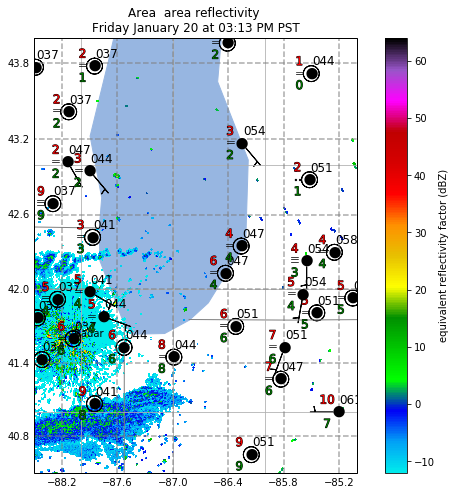

In [17]:
plot_kwargs = dict(path_effects=[mpatheffects.withStroke(foreground='black', linewidth=1)],
                   clip_on=True)
layout = StationPlotLayout()
layout.add_barb('eastward_wind', 'northward_wind', 'knots')
layout.add_value('NW', 'air_temperature', color='red', **plot_kwargs)
layout.add_value('SW', 'dew_point_temperature', color='green', **plot_kwargs)
layout.add_value('NE', 'air_pressure_at_sea_level', units='mbar', fmt=lambda v: format(10 * v, '03.0f')[-3:], clip_on=True)
layout.add_symbol('C', 'cloud_coverage', sky_cover, clip_on=True)
layout.add_symbol('W', 'present_weather', current_weather, clip_on=True)

display = radar_plus_obs('KLOT', datetime.utcnow(), 
                         bb={'west':-88.5, 'east':-85.0,'north':44, 'south':40.5},
                         station_radius=20000., station_layout=layout)
display.ax.add_feature(cartopy.feature.LAKES, zorder=0)

Now it's your turn!
==========